## Netflix Originals ML - IMDb Score Prediction
---

 - The purpose of this notebook is to build a selection of models that can be used in order to predict IMDb Score. 
 - Part 1 of this notebook will carry out preprocessing steps such as feature engineering, MLB processing and column transformations/scaling.
 - Part 2 will build a range of different models both with and without the use of PCA. These models will then be evaluated using RMSE and $R^2$. 
 - Feature importance will also be calculated in order to determine the most influential features.
 - The conclusions section will discuss the ways in which these results can be applied in a real life setting, as well as ways in which this work can be expanded upon.


---
## PART 1 : ML Preprocessing

In [44]:
import pandas as pd
import numpy as np
import sklearn
import os

In [45]:
pd.set_option("display.max_columns", None) #view all columns in dataframe.
os.chdir(r"C:\Users\oskar\Documents\Projects\Portfolio Projects\Netflix-Originals")

In [46]:
netflix = pd.read_csv("netflix_ml_prep.csv") #Loading in CSV from previous notebook
netflix.head(1)

,Title,Description,Genre,Rated,Running Time(mins),Release Date,Director,Cast,Primary Country,International,Lead Production Company,Multiple Production Companies,Wins,Nominations,IMDb Votes,IMDb Score,Plot,Cleaned_Description,clean_plot,plot_sentiment,plot_subjectivity,Release Year,Release Month,netflix_director,Popular Actors,Running_bin
0,Beasts of No Nation,"A drama based on the experiences of Agu, a chi...","Drama, War",Mature Audiences,138,2015-09-03,Cary Joji Fukunaga,"['Abraham Attah', 'Emmanuel Affadzi', 'Ricky A...",United States,0,Participant Media,1,31,59,84555.0,7.7,"Follows the journey of a young boy, Agu, who i...",a drama based on the experiences of agu a chil...,follows the journey of a young boy agu who is ...,-0.0875,0.458333,2015,9,0,0,Long


In [47]:
netflix.columns

Index(['Title', 'Description', 'Genre', 'Rated', 'Running Time(mins)',
       'Release Date', 'Director', 'Cast', 'Primary Country', 'International',
       'Lead Production Company', 'Multiple Production Companies', 'Wins',
       'Nominations', 'IMDb Votes', 'IMDb Score', 'Plot',
       'Cleaned_Description', 'clean_plot', 'plot_sentiment',
       'plot_subjectivity', 'Release Year', 'Release Month',
       'netflix_director', 'Popular Actors', 'Running_bin'],
      dtype='object')

In [48]:
#re-ordering the netflix dataframe for clarity
netflix = netflix[['Title', 'Description','Plot',
       'Cleaned_Description', 'clean_plot', 'plot_sentiment',
       'plot_subjectivity',  'Genre', 'Rated','netflix_director', 'Popular Actors', 'Running_bin', 'Running Time(mins)',
       'Release Date','Release Year', 'Release Month', 'Director', 'Cast', 'Primary Country', 'International',
       'Lead Production Company', 'Multiple Production Companies', 'Wins',
       'Nominations', 'IMDb Votes', 'IMDb Score']]

In [49]:
netflix.head(1)

,Title,Description,Plot,Cleaned_Description,clean_plot,plot_sentiment,plot_subjectivity,Genre,Rated,netflix_director,Popular Actors,Running_bin,Running Time(mins),Release Date,Release Year,Release Month,Director,Cast,Primary Country,International,Lead Production Company,Multiple Production Companies,Wins,Nominations,IMDb Votes,IMDb Score
0,Beasts of No Nation,"A drama based on the experiences of Agu, a chi...","Follows the journey of a young boy, Agu, who i...",a drama based on the experiences of agu a chil...,follows the journey of a young boy agu who is ...,-0.0875,0.458333,"Drama, War",Mature Audiences,0,0,Long,138,2015-09-03,2015,9,Cary Joji Fukunaga,"['Abraham Attah', 'Emmanuel Affadzi', 'Ricky A...",United States,0,Participant Media,1,31,59,84555.0,7.7


--- 
## Dropping Redundant Columns

In [50]:
#Description column not useful for ML, new columns have already been engineered from various columns. Thus, the originals are of no use.
netflix = netflix.drop(["Description" ,"Plot", "Cleaned_Description","clean_plot","Running_bin","Director","Cast","Release Date"], axis=1) 
netflix.head(1)

,Title,plot_sentiment,plot_subjectivity,Genre,Rated,netflix_director,Popular Actors,Running Time(mins),Release Year,Release Month,Primary Country,International,Lead Production Company,Multiple Production Companies,Wins,Nominations,IMDb Votes,IMDb Score
0,Beasts of No Nation,-0.0875,0.458333,"Drama, War",Mature Audiences,0,0,138,2015,9,United States,0,Participant Media,1,31,59,84555.0,7.7


---
## Genre Processing (Multi Label Binariser)
- Each string is converted into a list, unless the genre is one word, in which case it stays the same.
- Binariser is applied to genre column. Columns then assigned in DataFrame creation.
- Resetting index and concatenating to original dataframe.

In [51]:
from sklearn.preprocessing import MultiLabelBinarizer
netflix["Genre"] = netflix["Genre"].apply(lambda x: x.split(", ") if isinstance(x, str) else x) #convert string to a list

mlb = MultiLabelBinarizer() # intialising the multilabel binariser
netflix_genres = mlb.fit_transform(netflix["Genre"]) #applying the binariser and storing in netflix_genres.
display(mlb.classes_)

netflix_genres = netflix_genres.astype(int)
netflix_genres = pd.DataFrame(netflix_genres, columns=mlb.classes_)

# joining the 2 dataframes
netflix.reset_index(drop=True, inplace=True)
netflix_genres.reset_index(drop=True, inplace=True)

netflix = pd.concat([netflix, netflix_genres], axis=1)

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
       'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller',
       'War', 'Western'], dtype=object)

In [52]:
netflix =  netflix.drop("Genre", axis=1) #dropping genre column as no longer needed for ML

--- 
## Lead Production Company
- The Production companies in the dataframe are sparse - the majority of companies only occur once in the dataframe.
- The purpose of this code is to create a new column titled "Netflix_popular_company", where companies with more than 2 productions(for netflix) are indicated by a 1.


In [53]:
vc_lpc =netflix["Lead Production Company"].value_counts()
display(vc_lpc)

netflix_company = pd.DataFrame(netflix["Lead Production Company"].value_counts())     #Index jumbled in this code - this code selects those companies with more than 2 productions.
netflix_company.reset_index(inplace=True)
netflix_company = netflix_company[netflix_company["Lead Production Company"]>2]
netflix_company.reset_index(inplace=True, drop =True)

top_companies = []

for company in netflix_company["index"]:
    if company != "No Production Company Listed":
        top_companies.append(company)

netflix["Netflix_popular_company"] = netflix["Lead Production Company"].apply(lambda x: 1 if x in top_companies else 0) #Manually encoding the top production companies
netflix.drop("Lead Production Company", axis=1, inplace=True) #dropping the original column as new column has been feature engineered.


No Production Company Listed    118
Netflix                          53
Happy Madison Productions        12
MPCA                              9
RSVP Movies                       7
                               ... 
Labyrinthe Films                  1
MACRO                             1
Notorious Pictures                1
WWE Studios                       1
Basque Films                      1
Name: Lead Production Company, Length: 543, dtype: int64

In [54]:
netflix.head(3)

,Title,plot_sentiment,plot_subjectivity,Rated,netflix_director,Popular Actors,Running Time(mins),Release Year,Release Month,Primary Country,International,Multiple Production Companies,Wins,Nominations,IMDb Votes,IMDb Score,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western,Netflix_popular_company
0,Beasts of No Nation,-0.087500,0.458333,Mature Audiences,0,0,138,2015,9,United States,0,1,31,59,84555.0,7.7,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,The Ridiculous 6,0.075433,0.447078,Mature Audiences,0,1,120,2015,12,United States,0,0,0,0,51701.0,4.8,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,Pee-wee's Big Holiday,0.116667,0.577778,Parental Guidance,0,0,89,2016,3,United States,0,1,0,0,8470.0,6.1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


--- 

## DataFrame Data Types

In [55]:
netflix.dtypes

Title                             object
plot_sentiment                   float64
plot_subjectivity                float64
Rated                             object
netflix_director                   int64
Popular Actors                     int64
Running Time(mins)                 int64
Release Year                       int64
Release Month                      int64
Primary Country                   object
International                      int64
Multiple Production Companies      int64
Wins                               int64
Nominations                        int64
IMDb Votes                       float64
IMDb Score                       float64
Action                             int32
Adventure                          int32
Animation                          int32
Biography                          int32
Comedy                             int32
Crime                              int32
Documentary                        int32
Drama                              int32
Family          

In [56]:
#creating dummy variables for Genre/Country column.
ratings_dummies_df = pd.get_dummies(netflix["Rated"], prefix = "Rated", drop_first=True) #dropping first label occurence to avoid multicollinearity issues
netflix = pd.concat([netflix, ratings_dummies_df], axis=1) #Joining 2 dataframes together.
netflix.drop("Rated", axis=1, inplace=True)

country_dummies_df = pd.get_dummies(netflix["Primary Country"], prefix = "Country", drop_first=True) #dropping first label occurence to avoid multicollinearity issues
netflix = pd.concat([netflix, country_dummies_df], axis=1)
netflix.drop("Primary Country", axis=1, inplace=True)

In [57]:
#configuring dtypes for final mislabelled columns.
netflix["IMDb Votes"] = netflix["IMDb Votes"].astype(int) #Converting to integer dtype.
netflix.dtypes

Title                            object
plot_sentiment                  float64
plot_subjectivity               float64
netflix_director                  int64
Popular Actors                    int64
                                 ...   
Country_Thailand                  uint8
Country_Turkey                    uint8
Country_United Arab Emirates      uint8
Country_United Kingdom            uint8
Country_United States             uint8
Length: 84, dtype: object

---
## Data Transformations

- For the purpose of demonstrating various models in this notebook, features will be transformed. This will benefit linear models which assume normal distributions.
- This will not influence tree based models as they are non parametric - more for the benefit of linear models.
- The columns in the list "numerical_cols" will be checked for normality using the shapiro test.
- The Shapiro test is used to assess whether a set of data is normally distributed. The NULL hypothesis states that the data is from a normal distribution.
- In this case, if the p-value is greater than 0.05, there is not enough evidence to reject the null hypothesis.

Shapiro p-value for plot_sentiment: 4.40e-15
plot_sentiment NOT normally distributed

Shapiro p-value for plot_subjectivity: 9.76e-11
plot_subjectivity NOT normally distributed

Shapiro p-value for Running Time(mins): 2.93e-21
Running Time(mins) NOT normally distributed

Shapiro p-value for Release Year: 0.00e+00
Release Year NOT normally distributed

Shapiro p-value for Release Month: 1.50e-19
Release Month NOT normally distributed

Shapiro p-value for Wins: 0.00e+00
Wins NOT normally distributed

Shapiro p-value for Nominations: 0.00e+00
Nominations NOT normally distributed

Shapiro p-value for IMDb Votes: 0.00e+00
IMDb Votes NOT normally distributed



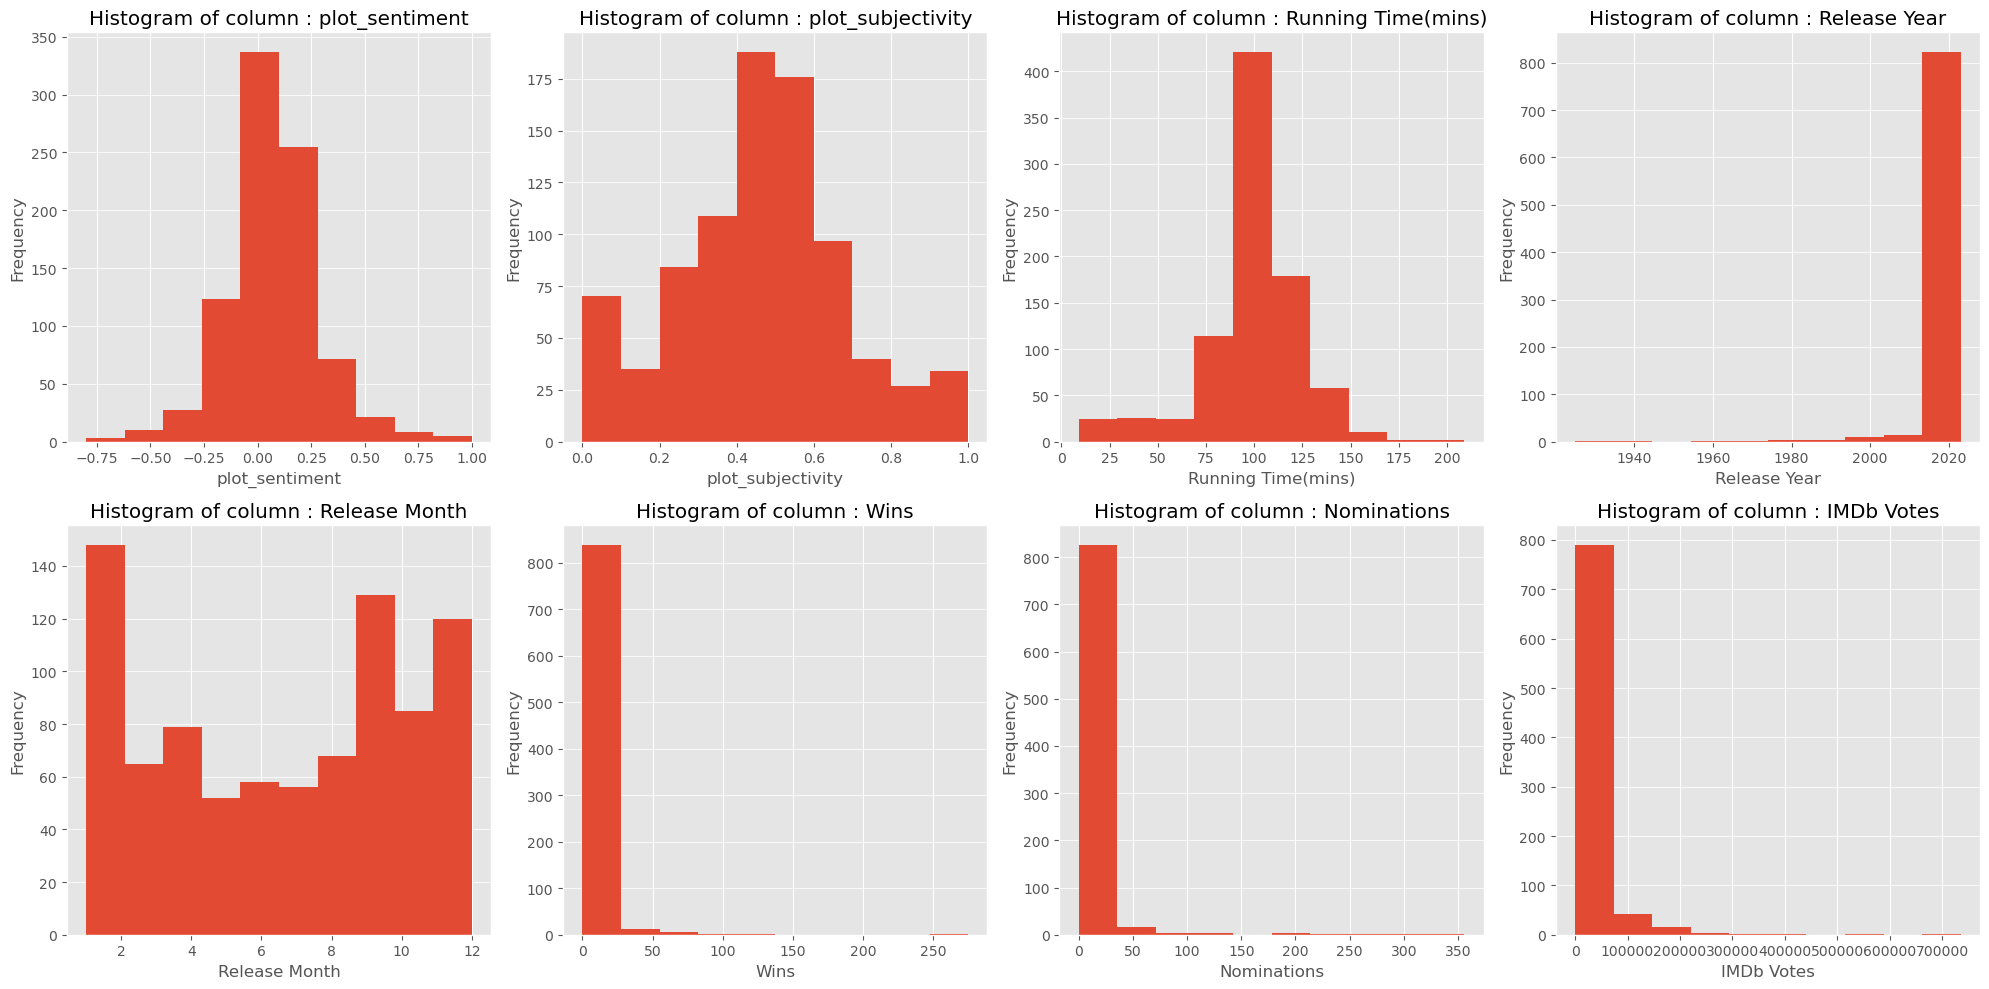

In [58]:
import matplotlib.pyplot as plt
from scipy import stats


numerical_cols = ['plot_sentiment', 'plot_subjectivity' , 'Running Time(mins)', 'Release Year', 'Release Month', 'Wins', 'Nominations','IMDb Votes']
n_cols = len(numerical_cols) #stores length of list created earlier
cols_per_row = (n_cols+1)//2

plt.figure(figsize=(5 * cols_per_row, 10)) #width x height

for i, column in enumerate(numerical_cols): #creates an index along with each value in the list.
    plt.subplot(2, cols_per_row, i + 1) #number of rows, number of columns,  index of subplot (index is 1 based, so we need to add 1 to convert 0 based index to a 1 based index.)
    netflix[column].hist() #plots a histogram for given column
    plt.title(f"Histogram of column : {column}") #f-string to appropriately label plot
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(axis="y", alpha=0.75)
    
    stat, p_value = stats.shapiro(netflix[column]) 

    if p_value >0.05:
        normal_d = "Normally Distributed"
    else:
        normal_d = "NOT normally distributed"
    
    print(f'Shapiro p-value for {column}: {p_value:.2e}\n{column} {normal_d}\n')

plt.tight_layout() #for visual clarity
plt.show()

- Note: The Shapiro test is very strict. Small deviances from normality can alter the p value, rejecting the null hypothesis of normality.
- In this case, the test states that all variables are NOT normally distributed, so transformations will be made to these variables.

- Yeo johnson transformation works for cases where values are both negative and positive.
- Standard Scaler sets a mean of 0 and standard deviation of 1.

In [59]:
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import train_test_split

- yj_transform holds the transforming method for transforming distributions so that they are normal.
- The Scaler will scale features so all in the same numeric range (more important for distance based models such as KNN).

c:\Users\oskar\anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\oskar\anaconda3\lib\site-packages\numpy\core\_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


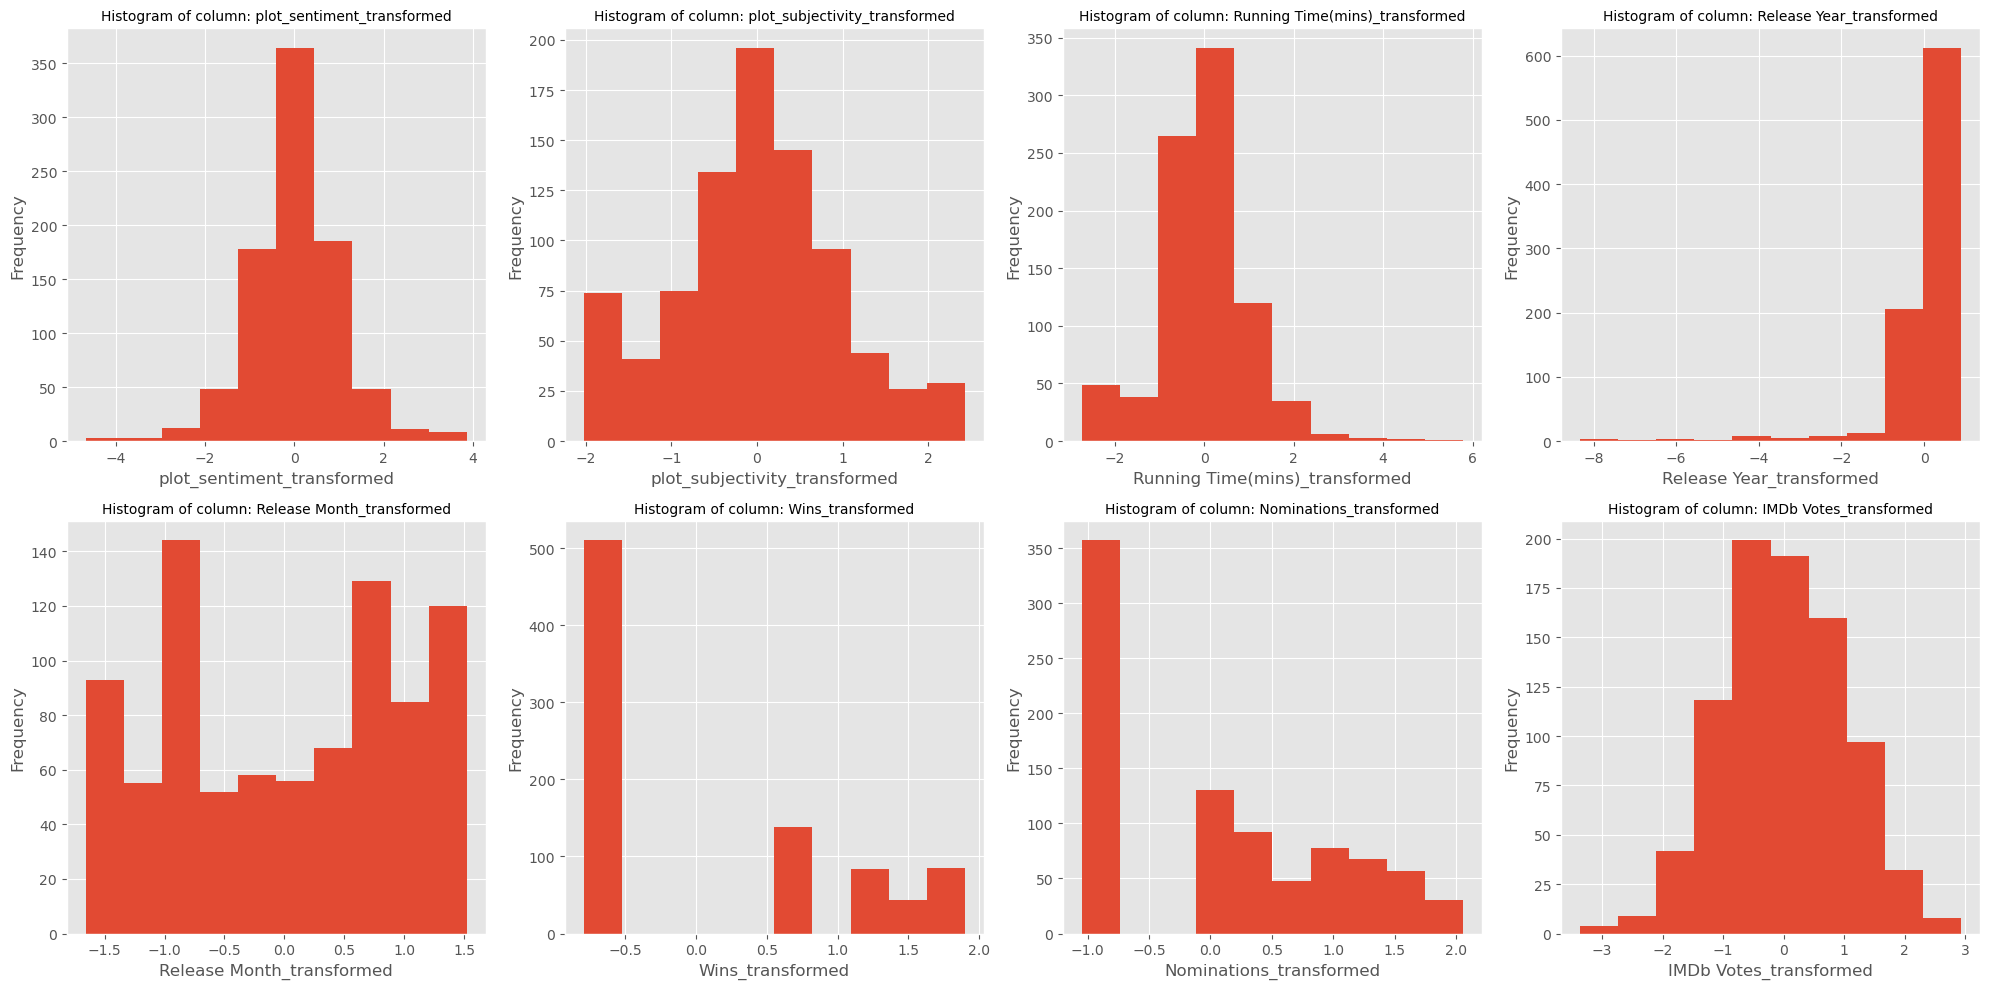

In [60]:
yj_transform = PowerTransformer(method='yeo-johnson') #yeo-johnson is good for non normal data. Crucially, it works for both positive and negative values, such as plot sentiment.
scaler = StandardScaler()   #initialiation

n_cols = len(numerical_cols) #stores length of list created earlier
cols_per_row = (n_cols+1)//2 #preparing for subplot of histograms

plt.figure(figsize=(5*cols_per_row,10))

for i ,col in enumerate(numerical_cols):
    transformed_col = yj_transform.fit_transform(netflix[[col]]) #transforming columns where applicable from the netflix DataFrame.
    scaled_col = scaler.fit_transform(transformed_col) #Taking the above transformed variables and scaling them.

    transformed_col_name = col + "_transformed" 
    netflix[transformed_col_name] = scaled_col #Naming new columns

    plt.subplot(2, cols_per_row, i+1)
    netflix[transformed_col_name].hist() 
    plt.title(f"Histogram of column: {transformed_col_name}", fontsize=10)
    plt.xlabel(transformed_col_name)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [61]:
for col in numerical_cols:
    netflix = netflix.drop(col, axis=1) #drops the original columns that were transformed as not needed for model.

netflix.head(1)

,Title,netflix_director,Popular Actors,International,Multiple Production Companies,IMDb Score,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western,Netflix_popular_company,Rated_Mature Audiences,Rated_Not Rated,Rated_Parental Guidance,Country_Australia,Country_Austria,Country_Belgium,Country_Brazil,Country_Cambodia,Country_Canada,Country_Chile,Country_China,Country_Czech Republic,Country_Denmark,Country_France,Country_Georgia,Country_Germany,Country_Greece,Country_Hong Kong,Country_Hungary,Country_Iceland,Country_India,Country_Indonesia,Country_Ireland,Country_Israel,Country_Italy,Country_Japan,Country_Mexico,Country_Netherlands,Country_New Zealand,Country_Nigeria,Country_Norway,Country_Pakistan,Country_Peru,Country_Philippines,Country_Poland,Country_South Africa,Country_South Korea,Country_Spain,Country_Sweden,Country_Thailand,Country_Turkey,Country_United Arab Emirates,Country_United Kingdom,Country_United States,plot_sentiment_transformed,plot_subjectivity_transformed,Running Time(mins)_transformed,Release Year_transformed,Release Month_transformed,Wins_transformed,Nominations_transformed,IMDb Votes_transformed
0,Beasts of No Nation,0,0,0,1,7.7,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.742994,-0.003543,1.770848,-0.84078,0.711656,1.846702,1.838475,1.475125


---
# PART 2 : Model Building, Testing and Evaluation
- The models created in the remainder of this notebook include:
    - KNN
    - Optimised KNN
    - Linear Regression
    - Random Forests
    - AdaBoost
        - With PCA
    - Gradient Boosting
        - With PCA
    - XGBoost (Extreme Gradient Boosting)

Evaluation Metrics used were:
- RMSE : Root Mean Squared Error tells us how mcuh error we can expect from our predictions. A score of 1 tells us that on average the predictions were 1 point off the actual scores. Lower RMSE indicates the model fits well to the Data.
- R Squared : Represents the proportion of variance in the target variable (IMDB Score) that is predictable from our features. A higher R squared indicates a better fit to the data and explains more variance around the mean of IMDb Score.

#### A summary of all results can be found at the end of the Notebook

In [62]:
X = netflix.drop(["IMDb Score", "Title"], axis=1)
feature_names = X.columns.tolist() #Will be needed for feature importance further in notebook.
X = netflix.drop(["IMDb Score", "Title"], axis=1).values #Drop the target variable. Drop the Title as will not be used as a feature.

y = netflix["IMDb Score"].values

X_pd = netflix.drop(["IMDb Score", "Title"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42) #Splitting into training and testing sets, where test set is 20% of the total size.

#PCA will be conducted later in this notebook. May potentially improve model performance.
from sklearn.decomposition import PCA
pca = PCA(n_components=5) #Using 5 principal components
X_train_pca = pca.fit_transform(X_train)  
X_test_pca = pca.transform(X_test)  

---
## Linear Regression
- Linear Regression Assumes a linear relationship between features and target.
- This model acts as a baseline compare against more complex models later in this notebook.

In [63]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

In [64]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
test_r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Test RMSE: ", test_rmse_lr)
print("Linear Regression Test R-squared: ", test_r2_lr)

lr_df = pd.DataFrame({
    "Model":["Linear Regression"],
    "RMSE": [test_rmse_lr],
    "R-Squared": [test_r2_lr]})

#creating a dataframe to store results
results_df = pd.DataFrame(columns=["Model", "RMSE", "R-Squared"]) 

results_df=pd.concat([results_df, lr_df], ignore_index=True) #Adding regression results to the results_df dataframe.
results_df

Linear Regression Test RMSE:  5451717046622.241
Linear Regression Test R-squared:  -4.150027425539869e+25


,Model,RMSE,R-Squared
0,Linear Regression,5.451717e+12,-4.150027e+25


---
## Baseline Model (KNN)

- This section uses the K Nearest Neighbours algorithm in order to predict the IMDb Scores of films from the Netflix Originals Dataframe.
- It finds the "K" nearest training examples that are closest to a test instance.
- KNN is non parametric, so it makes no assumptions about the distributions of features or their relationship with the target variable.
- KNN is a distance based model, so it is important that features were scaled, so that those on a much larger scale do not overpower those on smaller scales.
- In the code below, we use a default knn model, followed by a grid search which aimed to optimise model accuracy on the training data (Lower RMSE).
- Once an optimal model for the training data had been found, the model was re-evaluated on the test data.
- NOTE: A custom RMSE scorer was made for the purpose of Grid Searches.


In [65]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor() #Initialise the model
knn.fit(X_train, y_train) #Fitting the training data to the KNN regressor

y_pred = knn.predict(X_test) #Using the trained model to make prediction on the test data and storing in y_pred

rmse = np.sqrt(mean_squared_error(y_test, y_pred)) #defining rmse
print("KNN DEFAULT: rmse: ", rmse)
r2 = r2_score(y_test, y_pred) #defining $R^2$
print("KNN DEFAULT: r-squared: ", r2)

# Defining custom rmse scorer - as grid search cant accept a loss function alone as a scorer object.
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False) #make_scorer creates a scorer object. Greater is better set to false as we want RMSE to be as small as possible.

param_grid = {"n_neighbors":np.arange(1,100),"weights":["uniform", "distance"]}

grid = GridSearchCV(knn, param_grid, cv=5, scoring=rmse_scorer) #The scoring parameter expects a scorer object, not just a loss function.
#make_scorer was used to convert the loss function into a scorer object.
grid.fit(X_train, y_train)
print("Best Params:", grid.best_params_ , "Best Cross-Validated RMSE:", -grid.best_score_)

#GridSearch on Test Data
y_pred_knn = grid.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_knn))


print("Optimized Model - Test RMSE: ", test_rmse)
test_r2 = r2_score(y_test, y_pred_knn)
print("Optimized Model - Test R-squared: ", test_r2)


# knn=5 results
knn_df = pd.DataFrame({
    "Model":["KNN"],
    "RMSE": [0.7956], #hard-coding due to output error (figure displaying as a function rather than float).
    "R-Squared": [r2]
})
# optimised knn results
optimized_knn_df = pd.DataFrame({
    "Model": ["KNN OPTIMIZED"], 
    "RMSE": [test_rmse], 
    "R-Squared": [test_r2]
})

# Concatenate the original results DataFrame with the new DataFrame
results_df = pd.concat([results_df, knn_df, optimized_knn_df], ignore_index=True)

# Display the DataFrame
print(results_df)

KNN DEFAULT: rmse:  0.7956407393079565
KNN DEFAULT: r-squared:  0.1160689757706912
Best Params: {'n_neighbors': 11, 'weights': 'distance'} Best Cross-Validated RMSE: 0.7673287023611726
Optimized Model - Test RMSE:  0.7225112939147253
Optimized Model - Test R-squared:  0.27109046256911207
               Model          RMSE     R-Squared
0  Linear Regression  5.451717e+12 -4.150027e+25
1                KNN  7.956000e-01  1.160690e-01
2      KNN OPTIMIZED  7.225113e-01  2.710905e-01


- By optimising the number of neighbours, the root mean squared error decreased from 0.795 to 0.72, and the R squared increased from 0.11 to 0.27.
- Due to the poor performance of Linear Regression without hyper-parameter tuning, I went no further with this model.
- The poor performance was expected due to the complexity of relationship between features and target.

---
## Random Forests

- Random Forests is an ensemble method. It stacks/averages many descision tree ouputs and can handle complex relationships.
- It is not a distance based algorithm, and so scaling/transformation of variables has little or no impact.
- A random forest regressor is created below. Hyperparameters are tuned using the grid search.
- RF's are less prone to overfitting, due to them aggregating many decision trees. 

With Random Forests and other tree based models that are used in this notebook, they are less prone to overfitting for the following reasons:
- Averaging of many decision trees.
- Random Subset splitting at each node - creates diversity in data (exposes model to noise it would otherwise be unaware of).
- Depth of Trees - Hyperparameters like "max_depth" can control how tightly the model fits the training data.

These factors, among others allow us to regulate how well a model fits to training data, in turn influencing its ability to generalise on unseen datasets.

In [66]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)
display(rf.get_params()) #self-reminder of optional hyperparameters

param_grid = {
    'n_estimators': [100, 200],  #number of trees that are created before stopping.
    'max_depth': [5, 10], #controls the maximum depth a tree can get to (including the base/root)
    'min_samples_split': [2, 10],  #minimum number of samples to split at a node
    'min_samples_leaf': [1,2,3,4],  #minimum number of samples required to be at a leaf node.
}

grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring=rmse_scorer)
grid.fit(X_train, y_train)
print("Best Params:", grid.best_params_ , "Best Cross-Validated RMSE:", -grid.best_score_)

y_pred_rf = grid.predict(X_test)

test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print("Random Forests - Test RMSE: ", test_rmse_rf)
test_r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forests - Test R-squared: ", test_r2_rf)

rf_df = pd.DataFrame({
    "Model":["Random Forests"],
    "RMSE": [test_rmse_rf],
    "R-Squared": [test_r2_rf]})

results_df=pd.concat([results_df, rf_df],ignore_index=True)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Best Params: {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100} Best Cross-Validated RMSE: 0.7263877225564975
Random Forests - Test RMSE:  0.6133886086510968
Random Forests - Test R-squared:  0.47464149764196173


- The Cross Validated RMSE is an estimate of the models ability to generalise to new data. However, our model actaully performed better on the unseen data.

---
## AdaBoost

 - Short for Adaptive Boosting. An ensemble method made from many decision trees. 
 - Once a base model is established, new models attempt to correct the mistakes of previous models.
 - In each model iteration, incorrectly predicted instances have their weights increased, which makes the next model focus more on these weaknesses.
 - In the end, models are all combined so that models that perform well have more influence, whilst poor performing ones have less influence.
 - AdaBoost is typically more sensitive to noisey data and outliers.
 

In [67]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth=1, random_state=42) # max_depth being set to 1 creates "stumps" - weak learners as base estimators.
adb = AdaBoostRegressor(base_estimator=dt, random_state=42)

param_grid = {
    'n_estimators': [50, 150, 250],  
    'learning_rate': [0.1, 0.5, 1],   #scales the contribution that each tree has to the overall ensemble. High learning rate can overshoot an optimal model, whilst a low learning rate is more computationally expensive.
    'base_estimator__max_depth': [1, 2] #tuning to find best training data model.
}

grid = GridSearchCV(estimator=adb, param_grid=param_grid, cv=5, scoring=rmse_scorer)
grid.fit(X_train, y_train)
print("Best Params:", grid.best_params_ , "Best Cross-Validated RMSE:", -grid.best_score_)

y_pred_ada = grid.predict(X_test)

test_rmse_ada = np.sqrt(mean_squared_error(y_test, y_pred_ada))
print("AdaBoost - Test RMSE: ", test_rmse_ada)
test_r2_ada = r2_score(y_test, y_pred_ada)
print("AdaBoost - Test R-squared: ", test_r2_ada)

ada_df = pd.DataFrame({
    "Model":["AdaBoost"],
    "RMSE": [test_rmse_ada],
    "R-Squared": [test_r2_ada]})

results_df=pd.concat([results_df, ada_df],ignore_index=True)
results_df

Best Params: {'base_estimator__max_depth': 2, 'learning_rate': 0.1, 'n_estimators': 50} Best Cross-Validated RMSE: 0.7945631184133685
AdaBoost - Test RMSE:  0.6899979232379876
AdaBoost - Test R-squared:  0.33521697753554314


,Model,RMSE,R-Squared
0,Linear Regression,5.451717e+12,-4.150027e+25
1,KNN,7.956000e-01,1.160690e-01
2,KNN OPTIMIZED,7.225113e-01,2.710905e-01
3,Random Forests,6.133886e-01,4.746415e-01
4,AdaBoost,6.899979e-01,3.352170e-01


---
## Gradient Boosting

- Another ensemble method that builds models sequentially. Similarly to AdaBoost, it corrects the errors of previous trees.
- Unlike AdaBoost, these descision trees are usually deeper.
- To minimise errors at each step, GB fits a new tree to the residuals between observed and predicted values (Gradient Descent).
- Balancing the learning rate is crucial for preventing overfitting.



In [68]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42) #initialising the regressor.

param_grid = {
    'learning_rate': [0.1,0.12],
    'n_estimators': [100,104], #number of models built in total
    'max_depth': [2,3], #controls maximum depth of each tree: deeper trees allow for more complexity.
    'subsample': [0.6,0.8,1],  #controls the fraction of samples that are used for fitting base learners.
    'max_features': [0.6,0.8,1]  #fraction of features that are used when deciding on a node split.
}

grid = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, scoring=rmse_scorer)
grid.fit(X_train, y_train)
print("Best Params:", grid.best_params_ , "Best Cross-Validated RMSE:", -grid.best_score_)

y_pred_gbr = grid.predict(X_test)

test_rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
print("GBBoost - Test RMSE: ", test_rmse_gbr)
test_r2_gbr = r2_score(y_test, y_pred_gbr)
print("GBBoost - Test R-squared: ", test_r2_gbr)

gbr_df = pd.DataFrame({
    "Model":["GradientBoost"],
    "RMSE": [test_rmse_gbr],
    "R-Squared": [test_r2_gbr]})

results_df=pd.concat([results_df, gbr_df],ignore_index=True)
results_df

Best Params: {'learning_rate': 0.12, 'max_depth': 2, 'max_features': 0.8, 'n_estimators': 104, 'subsample': 1} Best Cross-Validated RMSE: 0.7007220898536597
GBBoost - Test RMSE:  0.5829845166223674
GBBoost - Test R-squared:  0.5254320621297366


,Model,RMSE,R-Squared
0,Linear Regression,5.451717e+12,-4.150027e+25
1,KNN,7.956000e-01,1.160690e-01
2,KNN OPTIMIZED,7.225113e-01,2.710905e-01
3,Random Forests,6.133886e-01,4.746415e-01
4,AdaBoost,6.899979e-01,3.352170e-01
5,GradientBoost,5.829845e-01,5.254321e-01


---
## XG Boost

- Extreme Gradient Boosting
- objective='reg:squarederror' : ensures squared errors are minimised.
- Include the regularisation terms which help reduce overfitting.

In [69]:
import xgboost as xgb

xgbr = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')

param_grid = {
    'learning_rate': [0.18],
    'n_estimators': [87,89,95],
    'max_depth': [2],
    'subsample': [0.5],
    'colsample_bytree': [0.5,0.8,0.9], # same as max_features
    #'reg_alpha': [], #These 2 prevent overfitting  by penalising the more complex models. L1 is Lasso: Adds a penalty term that can cause weights to be exactly 0.
    #'reg_lambda': [1]  #L2 is Ridge Regularisation: Weights distributed evently and prevents any one weight dominating.
}

grid_xgbr = GridSearchCV(estimator=xgbr, param_grid=param_grid, cv=5, scoring=rmse_scorer)

grid_xgbr.fit(X_train, y_train)
print("Best Params:", grid_xgbr.best_params_, "Best Cross-Validated RMSE:", -grid_xgbr.best_score_)
y_pred_xgbr = grid_xgbr.predict(X_test)

# Calculate RMSE and R^2 on the test set
test_rmse_xgbr = np.sqrt(mean_squared_error(y_test, y_pred_xgbr))
print("XGBoost - Test RMSE: ", test_rmse_xgbr)
test_r2_xgbr = r2_score(y_test, y_pred_xgbr)
print("XGBoost - Test R-squared: ", test_r2_xgbr)

# Add to results DataFrame
xgbr_df = pd.DataFrame({
    "Model":["XGBoost"],
    "RMSE": [test_rmse_xgbr],
    "R-Squared": [test_r2_xgbr]
})

results_df = pd.concat([results_df, xgbr_df], ignore_index=True)



Best Params: {'colsample_bytree': 0.9, 'learning_rate': 0.18, 'max_depth': 2, 'n_estimators': 95, 'subsample': 0.5} Best Cross-Validated RMSE: 0.7058438468790172
XGBoost - Test RMSE:  0.5761149602421394
XGBoost - Test R-squared:  0.5365502435051672


---
## Incorporating Principal Component Analysis
### PCA - AdaBoost

- Used to transform a high dimensional dataset into fewer dimensions, whilst maintaining the variability of the original datset.


In [70]:
dt = DecisionTreeRegressor(max_depth=1, random_state=42)
adb = AdaBoostRegressor(base_estimator=dt, random_state=42)

param_grid = {
    'n_estimators': [50, 150, 250],  
    'learning_rate': [0.1, 0.5, 1],  
    'base_estimator__max_depth': [1, 2]
}

grid = GridSearchCV(estimator=adb, param_grid=param_grid, cv=5, scoring=rmse_scorer)
grid.fit(X_train_pca, y_train)
print("Best Params:", grid.best_params_ , "Best Cross-Validated RMSE:", -grid.best_score_)

y_pred_ada_pca = grid.predict(X_test_pca) # Using the pca training and test set created earlier in the notebook

test_rmse_ada_pca = np.sqrt(mean_squared_error(y_test, y_pred_ada_pca))
print("AdaBoost - Test RMSE: ", test_rmse_ada_pca)
test_r2_ada_pca = r2_score(y_test, y_pred_ada_pca)
print("AdaBoost - Test R-squared: ", test_r2_ada_pca)

ada_df_pca = pd.DataFrame({
    "Model":["AdaBoost PCA"],
    "RMSE": [test_rmse_ada_pca],
    "R-Squared": [test_r2_ada_pca]})

results_df=pd.concat([results_df, ada_df_pca],ignore_index=True)

Best Params: {'base_estimator__max_depth': 2, 'learning_rate': 0.1, 'n_estimators': 50} Best Cross-Validated RMSE: 0.8398259873766717
AdaBoost - Test RMSE:  0.7509500118735671
AdaBoost - Test R-squared:  0.21258005785918233


### PCA - Gradient Boosting 

In [71]:
gbr = GradientBoostingRegressor(random_state=42)

param_grid = {
    'learning_rate': [0.05,0.1,0.15],
    'n_estimators': [50,100,150], 
    'max_depth': [3], 
    'subsample': [1],  
    'max_features': [0.5]  
}

grid = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, scoring=rmse_scorer)
grid.fit(X_train_pca, y_train)
print("Best Params:", grid.best_params_ , "Best Cross-Validated RMSE:", -grid.best_score_)

y_pred_gbr_pca = grid.predict(X_test_pca) # Using the pca training and test set created earlier in the notebook

test_rmse_gbr_pca = np.sqrt(mean_squared_error(y_test, y_pred_gbr_pca))
print("GBBoost - Test RMSE: ", test_rmse_gbr_pca)
test_r2_gbr_pca = r2_score(y_test, y_pred_gbr_pca)
print("GBBoost - Test R-squared: ", test_r2_gbr_pca)

gbr_df_pca = pd.DataFrame({
    "Model":["GradientBoost PCA"],
    "RMSE": [test_rmse_gbr_pca],
    "R-Squared": [test_r2_gbr_pca]})

results_df=pd.concat([results_df, gbr_df_pca],ignore_index=True)

print(results_df)

Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'max_features': 0.5, 'n_estimators': 100, 'subsample': 1} Best Cross-Validated RMSE: 0.8231563661353899
GBBoost - Test RMSE:  0.7436856210948601
GBBoost - Test R-squared:  0.22774074490246388
               Model          RMSE     R-Squared
0  Linear Regression  5.451717e+12 -4.150027e+25
1                KNN  7.956000e-01  1.160690e-01
2      KNN OPTIMIZED  7.225113e-01  2.710905e-01
3     Random Forests  6.133886e-01  4.746415e-01
4           AdaBoost  6.899979e-01  3.352170e-01
5      GradientBoost  5.829845e-01  5.254321e-01
6            XGBoost  5.761150e-01  5.365502e-01
7       AdaBoost PCA  7.509500e-01  2.125801e-01
8  GradientBoost PCA  7.436856e-01  2.277407e-01


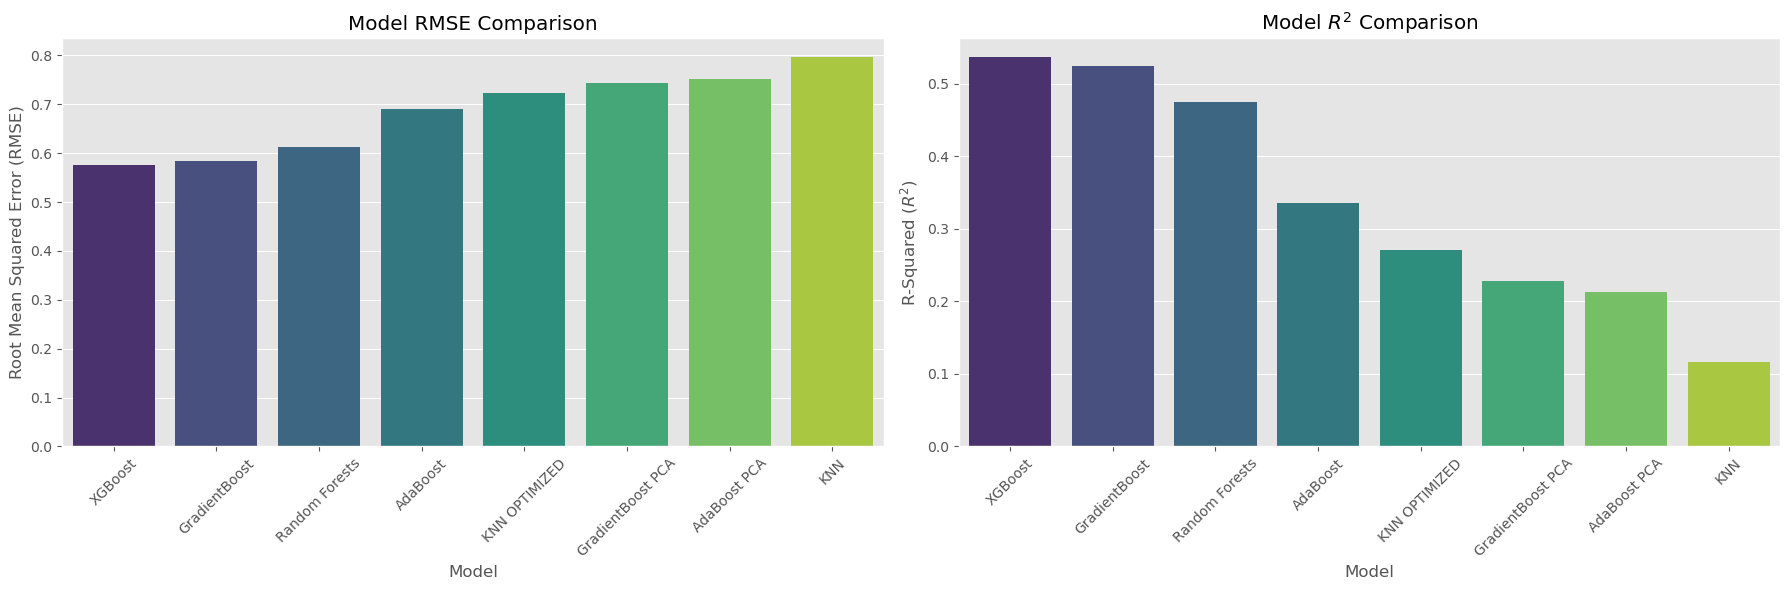

In [72]:
import seaborn as sns
sorted_results_df = results_df.sort_values("RMSE")
filtered_df = sorted_results_df[sorted_results_df["Model"] != "Linear Regression"] #Not including Linear Regression as is on a much larger scale than the other models.
#We already know it performs very poorly.

plt.figure(figsize=(18,6))

plt.subplot(121) #In a subplot with 1 row, 2 columns : this chart will take up first position
sns.barplot(y="RMSE", x="Model", data=filtered_df, palette="viridis")
plt.title("Model RMSE Comparison")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.xlabel("Model")
plt.xticks(rotation=45)

plt.subplot(122) #In a subplot with 1 row, 2 columns : this chart will take up second position
sns.barplot(y="R-Squared", x="Model", data=filtered_df, palette="viridis")
plt.title("Model $R^2$ Comparison")
plt.ylabel("R-Squared ($R^2$)")
plt.xlabel("Model")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

- As expected, Extreme Gradient Boost performed the best in terms of both RMSE and $R^2$, whilst KNN performed the worst.

---
## Feature Importance

- Given XG Boost Performed the best on the training and test data, we will extract feature importance from its model.
- This information can  aid in feature selection for future model creation as well as model interpretation.
- The bar chart implies that the number of wins and  Documentary (binary) type were the two features influencing the model the most.

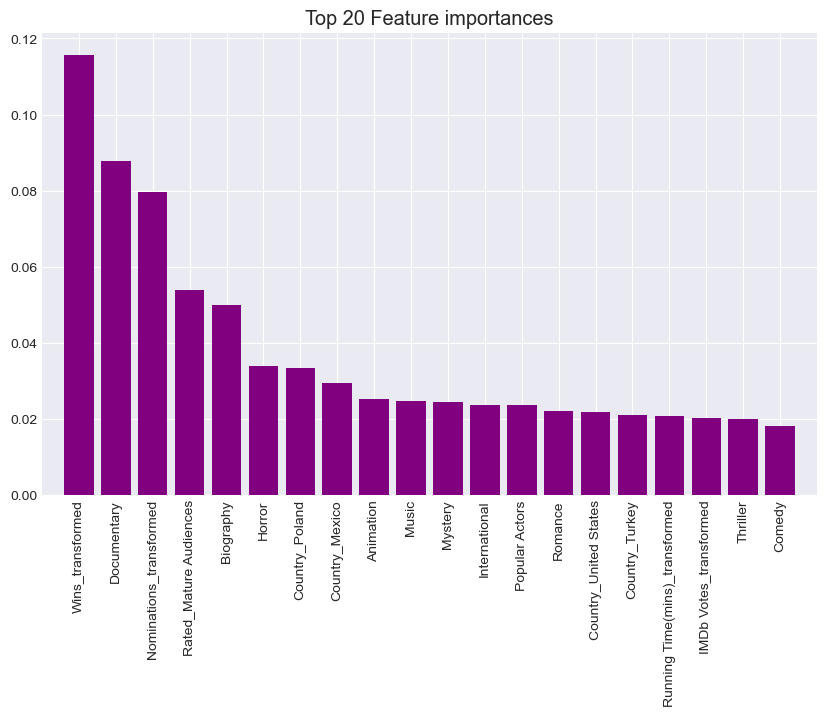

In [73]:
importances = grid_xgbr.best_estimator_.feature_importances_ #extract the feature importances from the generated grid.
indices = np.argsort(importances)[::-1] #sort the importances in descending order.

features = 20 # 20 to fit in the visualisation

plt.figure(figsize=(10,6))
plt.style.use('seaborn-darkgrid')
plt.title("Top 20 Feature importances")
plt.bar(range(features), importances[indices][:features], color = "purple")  # only plot the top 20 features
plt.xticks(range(features), [feature_names[i] for i in indices[:features]], rotation=90)  
plt.xlim([-1, features])
plt.show()


--- 
## Conclusions

### Model Evaluation
- XGBoost was the model that had the greatest predictive power for the Netflix Originals Dataset. It attained an RMSE OF 0.5761 and a $R^2$ of 0.5366.
- This model performing best is not a suprise. It is a superior version of Gradient boosting, an already powerful modelling tool.
- The models that utilised PCA did not perform well in comparison to those that did not use it. This could be due to the small size of the dataset, both in terms of data points and dimensions.
- Linear Regression performed very poorly due to the complex and non linear nature of the data within the dataset.

### Real Life Implications
- If a production company knows which features significantly impact an IMDb score, they can focus on improving those aspects in its movies to achieve higher ratings.
- This means businesses can allocated resources more effectively, saving money whilst simultaneously boosting ratings.
- Feature importance could help a production company decide what script to take from page to screen (Documentary would likely perform better than Horror)
- Netflix itself could use recommendations in order to edge their competition in the online streaming space.
- Data could be used to enhance use recommendations.


#### Limitations + Future Work
- In most cases, the RMSE was lower(better) on the test data than it was on the training data. Although predictions were better in this instance, on other sets of unseen data, the model may not generalise as well.
- A potential reason for this lies in the way the data was split. Given the small nature of the dataset (<1000), it is possible that one batch of data had some "harder to predict" instances.
---
- Future work could use more titles (Not only Netflix Originals) to increase the size of the dataset.
- It could use more features, to improve the accuracy of the models. For example, more work could be done with NLP.
- Although difficult to acquire, information about budgets and box office would be of great help in improving model abilities.
- Using ensemble methods/stacking models and voting could improve performance.
- If more computational power is available, more experimentation with hyper-parameters can be undertaken.
- More advanced modelling such as that with Neural Networks could be undertaken to imporove accuracy scores.